In [1]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import plot_roc_curve, log_loss, f1_score, fbeta_score, recall_score, precision_score, confusion_matrix
# from sklearn.metrics import log_loss, f1_score, fbeta_score, recall_score, precision_score, confusion_matrix
import urllib.request, json
from skimage.filters import threshold_otsu
from pprint import pprint

# Homemade functions required
from data_prep_functions import *
from interpro_scraping import interpro_scraping_pandas
from uniprot_netsurfp_scraping import *

# Generate features and names from predownloaded properties and LC-MS/MS data 

In [2]:
############# EDIT, FILL IN DATA HERE ############
data_file = '2020-02-03 MS compiled for ML project.xlsx'  # needs xlsx at the end 

plasma_prop_sheet = 'Protein properties, plasma'
plasma_mass_spec_sheet = '(GT)15-SWCNT, plasma'

csf_prop_sheet = 'Protein properties, CSF'
csf_mass_spec_sheet = '(GT)15-SWCNT, CSF'
###################################################

In [3]:
############ NO EDITS REQUIRED ##############

data_filepath = "data/" + data_file

# load data

plasma_raw_data = pd.read_excel(data_filepath, sheet_name= plasma_prop_sheet, thousands=',')
csf_raw_data = pd.read_excel(data_filepath, sheet_name= csf_prop_sheet, thousands=',')

plasma_mass_spec_data = pd.read_excel(data_filepath, sheet_name=plasma_mass_spec_sheet, header=2, thousands=',')
csf_mass_spec_data = pd.read_excel(data_filepath, sheet_name=csf_mass_spec_sheet, header=2, thousands=',')

# clean up data 

plasma_cleaned_data = clean_up_data_v2(plasma_raw_data) # clean_up_data_biopy(plasma_raw_data)
csf_cleaned_data = clean_up_data_v2(csf_raw_data) #clean_up_data_biopy(csf_raw_data)


plasma_cleaned_data, csf_cleaned_data = normalize_mass_length(plasma_cleaned_data, csf_cleaned_data)

c:\Users\Venus\Desktop\protein-corona-ml-05192021\data_prep_functions.py:184: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['metal_binding_'+metals[j]][i] = len(metal_found)
c:\Users\Venus\Desktop\protein-corona-ml-05192021\data_prep_functions.py:267: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['nucleotide_binding_'+j][i] = regex_list_type.count(j)
c:\Users\Venus\Desktop\protein-corona-ml-05192021\data_prep_functions.py:569: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

In [4]:
netsurfp_data = pd.read_excel("data/"+'netsurfp_2_lcms_proteins_processed.xlsx')

plasma_complete_data = pd.merge(plasma_cleaned_data, netsurfp_data, left_on='Entry', right_on='entry')
csf_complete_data = pd.merge(csf_cleaned_data, netsurfp_data, left_on='Entry', right_on='entry')

for df in [plasma_complete_data, csf_complete_data]:
    for col in ['asa_sum']:
        df[col+'_normalized'] = df[col] / df['Mass']

csf_complete_data.head()

,Entry,Protein names,Length,Mass,Sequence,dna_binding_length,calcium_binding_zones,calcium_binding_length,nucleotide_binding_zones,nucleotide_binding_length,...,fraction_exposed_exposed_S,fraction_exposed_exposed_T,fraction_exposed_exposed_V,fraction_exposed_exposed_W,fraction_exposed_exposed_Y,nsp_secondary_structure_coil,nsp_secondary_structure_sheet,nsp_secondary_structure_helix,nsp_disordered,asa_sum_normalized
0,P02768,Serum albumin,609,69367,MKWVTFISLLFLFSSAYSRGVFRRDAHKSEVAHRFKDLGEENFKAL...,0.0,0,0.0,0,0.0,...,0.050000,0.067647,0.035294,0.002941,0.011765,0.286,0.000,0.714,0.038,0.464794
1,P02766,Transthyretin (ATTR) (Prealbumin) (TBPA),147,15887,MASHRLLLLCLAGLVFVSEAGPTGTGESKCPLMVKVLDAVRGSPAI...,0.0,0,0.0,0,0.0,...,0.105263,0.063158,0.042105,0.010526,0.021053,0.551,0.381,0.068,0.197,0.602589
2,P01009,Alpha-1-antitrypsin (Alpha-1 protease inhibito...,418,46737,MPSSVSWGILLLAGLCCLVPVSLAEDPQGDAAQKTDTSHHDQDHPT...,0.0,0,0.0,0,0.0,...,0.076577,0.067568,0.031532,0.004505,0.000000,0.400,0.330,0.270,0.105,0.463058
3,P41222,Prostaglandin-H2 D-isomerase (EC 5.3.99.2) (Be...,190,21029,MATHHTLWMGLALLGVLGDLQAAPEAQVSVQPNFQQDKFLGRWFSA...,0.0,0,0.0,0,0.0,...,0.071429,0.095238,0.039683,0.023810,0.000000,0.463,0.400,0.137,0.137,0.568527
4,P02787,Serotransferrin (Transferrin) (Beta-1 metal-bi...,698,77064,MRLAVGALLVCAVLGLCLAVPDKTVRWCAVSEHEATKCQSFRDHMK...,0.0,0,0.0,0,0.0,...,0.062130,0.047337,0.026627,0.000000,0.005917,0.474,0.186,0.340,0.030,0.419599


In [5]:
###### MASS SPEC DATA, LIKELY REQUIRED (THRESHOLD METHOD) ########

plasma_labels = plasma_mass_spec_data[['Accession', 'NP average','NP fold change']]
csf_labels = csf_mass_spec_data[['Accession', 'NP average', 'NP fold change']]

## For OTSU, Comment out if not using ###

# plasma_labels['Corona'] = (plasma_labels['NP average'] > criteria_plas).astype(int)
# csf_labels['Corona'] = (csf_labels['NP average'] > criteria_csf).astype(int)

## for TRAVIS, Comment out if not using ## 

thresh_power = 2.25 # change based on previous cell
fluids_type_list=['plasma', 'csf']
data_sheets = [plasma_labels, csf_labels]
for k in range(2):
    sheet = data_sheets[k]
    fluid_type = fluids_type_list[k]

    print(f'\n{fluid_type.capitalize()} running')

    num_proteins = np.zeros(100)
    for i in np.arange(0,100,1):
        thresh = i/100
        index = (sheet['NP average']>thresh)
        num_proteins[i] = (np.count_nonzero(index))

    x = np.arange(0,1,.01)
    num_proteins_above_1_abundance = min(num_proteins)
    biexponent_dist = num_proteins - num_proteins_above_1_abundance
    num_protein_thresh = np.max(biexponent_dist)/pow(np.e,thresh_power)
    cutoff_thresh_value = min(x[(biexponent_dist<num_protein_thresh)&(biexponent_dist>0)], default=0)
    sheet['Corona'] = ((sheet['NP average']>cutoff_thresh_value) | (sheet['NP fold change']>1)).astype(int)
    


### end different thresh methods



plasma_labels = plasma_labels.drop(['NP average', 'NP fold change'], axis=1)
csf_labels = csf_labels.drop(['NP average', 'NP fold change'], axis=1)



# checks for any accession lists
plasma_labels = accession_expansion(plasma_labels) 
csf_labels = accession_expansion(csf_labels)

plasma_total_data_names = pd.merge(plasma_labels, plasma_complete_data, left_on='Accession', right_on='Entry')
csf_total_data_names = pd.merge(csf_labels, csf_complete_data, left_on='Accession', right_on='Entry')

plasma_to_export =plasma_total_data_names.drop(['Accession','Entry', 'entry', 'Sequence', 'Length', 'Mass'], axis=1)
csf_to_export = csf_total_data_names.drop(['Accession','Entry', 'entry', 'Sequence', 'Length', 'Mass'], axis=1)

plasma_to_export.to_excel("data/"+'gt15_plasma_features_names_max_features.xlsx')
csf_to_export.to_excel("data/"+'gt15_csf_features_names_max_features.xlsx')



Plasma running

Csf running
<ipython-input-5-716e6644dd73>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sheet['Corona'] = ((sheet['NP average']>cutoff_thresh_value) | (sheet['NP fold change']>1)).astype(int)


In [8]:
plasma_to_export.head()

,Corona,Protein names,frac_aa_A,frac_aa_C,frac_aa_D,frac_aa_E,frac_aa_F,frac_aa_G,frac_aa_H,frac_aa_I,...,fraction_exposed_exposed_S,fraction_exposed_exposed_T,fraction_exposed_exposed_V,fraction_exposed_exposed_W,fraction_exposed_exposed_Y,nsp_secondary_structure_coil,nsp_secondary_structure_sheet,nsp_secondary_structure_helix,nsp_disordered,asa_sum_normalized
0,0,Serum albumin,0.103448,0.057471,0.059113,0.101806,0.057471,0.021346,0.026273,0.014778,...,0.050000,0.067647,0.035294,0.002941,0.011765,0.286,0.000,0.714,0.038,0.464794
1,1,Haptoglobin (Zonulin) [Cleaved into: Haptoglob...,0.073892,0.029557,0.061576,0.061576,0.019704,0.076355,0.032020,0.044335,...,0.050633,0.029536,0.054852,0.004219,0.037975,0.559,0.372,0.069,0.074,0.491087
2,1,Immunoglobulin kappa constant (Ig kappa chain ...,0.065421,0.028037,0.046729,0.065421,0.037383,0.037383,0.018692,0.009346,...,0.189189,0.094595,0.040541,0.000000,0.013514,0.383,0.514,0.103,0.009,0.557026
3,1,Immunoglobulin heavy constant gamma 1 (Ig gamm...,0.039394,0.027273,0.039394,0.051515,0.030303,0.054545,0.027273,0.015152,...,0.132159,0.101322,0.026432,0.004405,0.017621,0.485,0.467,0.048,0.012,0.517634
4,0,Serotransferrin (Transferrin) (Beta-1 metal-bi...,0.087393,0.057307,0.064470,0.060172,0.040115,0.074499,0.027221,0.022923,...,0.062130,0.047337,0.026627,0.000000,0.005917,0.474,0.186,0.340,0.030,0.419599


# Download protein property data

 ## use this if you have a list of protein targets

In [19]:
# only_uniprot_data = pd.read_excel('uniprot_1000_cytoplasm.xlsx')['Entry'] # for use when creating no netsurfp sets
chosen_list = ["Q01995", 'Q13148', 'P16070', 'P00698', 'P00338', 'P07998', 'Q8MU52', 'O00560'] 
test_data = uniprot_data_scraping(chosen_list) # replace with only_uniprot_data for no netsurf p

(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)


In [20]:
test_data
#copy_df = test_data.copy()

,Entry,Protein names,Status,Protein families,Length,Mass,Sequence,Binding site,DNA binding,Metal binding,...,Helix,Turn,Coiled coil,Compositional bias,Domain [CC],Domain [FT],Motif,Region,Repeat,Zinc finger
0,Q01995,Transgelin (22 kDa actin-binding protein) (Pro...,reviewed,Calponin family,201,22611,MANKGPSYGMSREVQSKIEKKYDEELEERLVEWIIVQCGPDVGRPD...,0,0,0,...,0,0,0,0,0,"DOMAIN 24..137; /note=""Calponin-homology (CH)...",0,0,"REPEAT 175..200; /note=""Calponin-like""",0
1,Q13148,TAR DNA-binding protein 43 (TDP-43),reviewed,0,414,44740,MSEYIRVTEDENDEPIEIPSEDDGTVLLSTVTAQFPGACGLRYRNP...,0,0,0,...,"HELIX 28..32; /evidence=""ECO:0007744|PDB:5MDI...","TURN 46..48; /evidence=""ECO:0007744|PDB:5MDI""...",0,"COMPBIAS 274..413; /note=""Gly-rich""",DOMAIN: Consists of an N-terminal domain (NTD)...,"DOMAIN 104..200; /note=""RRM 1""; /evidence=""E...","MOTIF 82..98; /note=""Nuclear localization sig...","REGION 216..414; /note=""Interaction with UBQL...",0,0
2,P16070,CD44 antigen (CDw44) (Epican) (Extracellular m...,reviewed,0,742,81538,MDKFWWHAAWGLCLVPLSLAQIDLNITCRFAGVFHVEKNGRYSISR...,"BINDING 41; /note=""Hyaluronan""; /evidence=""E...",0,0,...,"HELIX 46..55; /evidence=""ECO:0007744|PDB:4PZ3...","TURN 150..152; /evidence=""ECO:0007744|PDB:1POZ""",0,"COMPBIAS 150..158; /note=""Arg/Lys-rich (basic)""",DOMAIN: The lectin-like LINK domain is respons...,"DOMAIN 32..120; /note=""Link""; /evidence=""ECO...",0,"REGION 224..649; /note=""Stem""; REGION 673..69...",0,0
3,P00698,"Lysozyme C (EC 3.2.1.17) (1,4-beta-N-acetylmur...",reviewed,Glycosyl hydrolase 22 family,147,16239,MRSLLILVLCFLPLAALGKVFGRCELAAAMKRHGLDNYRGYSLGNW...,"BINDING 119; /note=""Substrate""",0,0,...,"HELIX 23..32; /evidence=""ECO:0007744|PDB:2VB1...","TURN 33..37; /evidence=""ECO:0007744|PDB:2HSO""...",0,0,0,"DOMAIN 19..147; /note=""C-type lysozyme""; /ev...",0,0,0,0
4,P00338,L-lactate dehydrogenase A chain (LDH-A) (EC 1....,reviewed,"LDH/MDH superfamily, LDH family",332,36689,MATLKDQLIYNLLKEEQTPQNKITVVGVGAVGMACAISILMKDLAD...,"BINDING 99; /note=""NAD""; /evidence=""ECO:0000...",0,0,...,"HELIX 4..8; /evidence=""ECO:0007744|PDB:5W8J"";...","TURN 216..219; /evidence=""ECO:0007744|PDB:5W8J""",0,0,0,0,0,0,0,0
5,P07998,Ribonuclease pancreatic (EC 4.6.1.18) (HP-RNas...,reviewed,Pancreatic ribonuclease family,156,17644,MALEKSLVRLLLLVLILLVLGWVQPSLGKESRAKKFQRQHMDSDSS...,"BINDING 35; /note=""Substrate""; /evidence=""EC...",0,0,...,"HELIX 32..40; /evidence=""ECO:0007744|PDB:2E0J...","TURN 47..50; /evidence=""ECO:0007744|PDB:1H8X""...",0,0,0,0,0,"REGION 69..73; /note=""Substrate binding""; /e...",0,0
6,Q8MU52,Glutathione S-transferase (EC 2.5.1.18) (PfGST),reviewed,GST superfamily,211,24789,MGDNIVLYYFDARGKAELIRLIFAYLGIEYTDKRFGVNGDAFVEFK...,"BINDING 105; /note=""Glutathione""; /evidence=...",0,0,...,"HELIX 17..26; /evidence=""ECO:0007744|PDB:4ZXG...","TURN 14..16; /evidence=""ECO:0007744|PDB:4ZXG""...",0,0,0,"DOMAIN 3..87; /note=""GST N-terminal""; /evide...",0,"REGION 58..59; /note=""Glutathione binding""; ...",0,0
7,O00560,Syntenin-1 (Melanoma differentiation-associate...,reviewed,0,298,32444,MSLYPSLEDLKVDKVIQAQTAFSANPANPAILSEASAPIPHDGNLY...,"BINDING 215; /note=""Phosphatidylinositol-4,5-...",0,0,...,"HELIX 146..149; /evidence=""ECO:0007744|PDB:1W...",0,0,0,0,"DOMAIN 114..193; /note=""PDZ 1""; /evidence=""E...","MOTIF 3..7; /note=""LYPX(n)L motif 1""; /evide...","REGION 2..60; /note=""Interaction with PDCD6IP...",0,0


In [23]:
test_data['Calcium binding'] = 0
test_data['Activity regulation'] = 0
test_data.head()

for i in range(8):

    testing = test_data.iloc[i*1:i*1 + 1]
    try:
        testing_cleaned = clean_up_data_biopy(testing)
    except:
        print(f'error at {i}')

test_data_corrected = test_data.copy()#.drop([405, 680, 707, 792]) # run above once and run again with error drops if there are any
test_cleaned_data = clean_up_data_biopy(test_data_corrected)


plasma_raw_data = pd.read_excel(data_filepath, sheet_name= plasma_prop_sheet, thousands=',')
plasma_cleaned_data = clean_up_data_biopy(plasma_raw_data)

test_cleaned_data['length'] = test_cleaned_data['Length'] / plasma_cleaned_data.Length.max()
test_cleaned_data['mass'] = test_cleaned_data['Mass'] / plasma_cleaned_data.Mass.max()
test_cleaned_data['molecular_weight'] = test_cleaned_data['molecular_weight'] / plasma_cleaned_data.molecular_weight.max()
plasma_cleaned_data, test_cleaned_data = normalize_mass_length(plasma_cleaned_data, test_cleaned_data)

In [24]:
netsurfp_test_data = pd.read_excel("data/"+'netsurfp_2_proteins_selected_for_testing_processed.xlsx')  # load in the netsurfp data from the same set of data

test_complete_data = pd.merge(test_cleaned_data, netsurfp_test_data, left_on='Entry', right_on='entry')


for df in [test_complete_data]:
    for col in ['asa_sum']:
        df[col+'_normalized'] = df[col] / df['Mass']

test_complete_data.head()

,Entry,Protein names,Sequence,Length,Mass,frac_aa_A,frac_aa_C,frac_aa_D,frac_aa_E,frac_aa_F,...,fraction_exposed_exposed_S,fraction_exposed_exposed_T,fraction_exposed_exposed_V,fraction_exposed_exposed_W,fraction_exposed_exposed_Y,nsp_secondary_structure_coil,nsp_secondary_structure_sheet,nsp_secondary_structure_helix,nsp_disordered,asa_sum_normalized
0,Q01995,Transgelin (22 kDa actin-binding protein) (Pro...,MANKGPSYGMSREVQSKIEKKYDEELEERLVEWIIVQCGPDVGRPD...,201,22611,0.054726,0.004975,0.049751,0.074627,0.034826,...,0.079137,0.028777,0.043165,0.000000,0.028777,0.607,0.000,0.393,0.065,0.560393
1,Q13148,TAR DNA-binding protein 43 (TDP-43),MSEYIRVTEDENDEPIEIPSEDDGTVLLSTVTAQFPGACGLRYRNP...,414,44740,0.062802,0.014493,0.053140,0.053140,0.053140,...,0.126246,0.019934,0.016611,0.016611,0.009967,0.676,0.198,0.126,0.341,0.576662
2,P16070,CD44 antigen (CDw44) (Epican) (Extracellular m...,MDKFWWHAAWGLCLVPLSLAQIDLNITCRFAGVFHVEKNGRYSISR...,742,81538,0.056604,0.012129,0.061995,0.067385,0.030997,...,0.125547,0.129927,0.029197,0.021898,0.013139,0.902,0.073,0.026,0.798,0.799411
3,P00698,"Lysozyme C (EC 3.2.1.17) (1,4-beta-N-acetylmur...",MRSLLILVLCFLPLAALGKVFGRCELAAAMKRHGLDNYRGYSLGNW...,147,16239,0.095238,0.061224,0.047619,0.013605,0.027211,...,0.087912,0.076923,0.032967,0.000000,0.021978,0.537,0.075,0.388,0.122,0.550834
4,P00338,L-lactate dehydrogenase A chain (LDH-A) (EC 1....,MATLKDQLIYNLLKEEQTPQNKITVVGVGAVGMACAISILMKDLAD...,332,36689,0.054217,0.015060,0.054217,0.054217,0.021084,...,0.036585,0.054878,0.024390,0.012195,0.042683,0.319,0.205,0.476,0.006,0.433721


In [26]:
# test_data_done=test_complete_data.drop(['Entry', 'entry', 'Sequence', 'Length', 'Mass'], axis=1)
# test_data_done=test_cleaned_data.drop(['Entry', 'Sequence', 'Length', 'Mass'], axis=1)
# test_data_done.head()
test_data_done.to_excel("data/"+'proteins_selected_for_testing_complete.xlsx')

## use this if you want to download data based off of a link

In [12]:
### done to check bias in our classifier #### 
covid_link = 'https://covid-19.uniprot.org/uniprotkb?query=id&format=html'
cytoplasm_link = 'https://www.uniprot.org/uniprot/?query=locations:(location:%22Cytoplasm%20%5BSL-0086%5D%22)&fil=organism%3A%22Homo+sapiens+%28Human%29+%5B9606%5D%22+AND+reviewed%3Ayes&limit=75'
dendritic_spine ='https://www.uniprot.org/uniprot/?query=locations:(location:%22Dendritic%20spine%20%5BSL-0284%5D%22)&fil=organism%3A%22Homo+sapiens+%28Human%29+%5B9606%5D%22+AND+reviewed%3Ayes&limit=150'
clatherin_pit = 'https://www.uniprot.org/uniprot/?query=locations:(location:%22Clathrin-coated%20pit%20%5BSL-0069%5D%22)&fil=organism%3A%22Homo+sapiens+%28Human%29+%5B9606%5D%22+AND+reviewed%3Ayes'
nucleus = 'https://www.uniprot.org/uniprot/?query=locations%3A%28location%3A%22Nucleus+%5BSL-0191%5D%22%29+reviewed%3Ayes+organism%3A%22Homo+sapiens+%28Human%29+%5B9606%5D%22&sort=score&limit=120'

entry_check = pd.read_html(nucleus, header=0)
entry_list = entry_check[0]['Entry']

verification_set = uniprot_data_scraping(entry_list)

verification_set['Calcium binding'] = 0
verification_set['Activity regulation'] = 0
verification_cleaned_data = clean_up_data_biopy(verification_set)


plasma_raw_data = pd.read_excel(data_file, sheet_name= plasma_prop_sheet, thousands=',')
plasma_cleaned_data = clean_up_data_biopy(plasma_raw_data)
plasma_cleaned_data, test_cleaned_data = normalize_mass_length(plasma_cleaned_data, verification_cleaned_data)

# netsurfp_verification_data = pd.read_excel('netsurfp_verification_data_processed_nucleus.xlsx')

# verification_complete_data = pd.merge(verification_cleaned_data, netsurfp_verification_data, left_on='Entry', right_on='entry')


# for df in [verification_complete_data]:
#     for col in ['asa_sum']:
#         df[col+'_normalized'] = df[col] / df['Mass']
test_cleaned_data.head()
# verification_complete_data.head()

# Delete data below this

Otsu's Method (Plasma, CSF)
30.98218916091797 11.057389430039063

Plasma 

Threshold power: 1, Abundance cutoff threshold: 0.08, Number of proteins in corona: 44
Threshold power: 2, Abundance cutoff threshold: 0.33, Number of proteins in corona: 32
Threshold power: 3, Abundance cutoff threshold: 0.87, Number of proteins in corona: 27

now with fold change
19.497610382086442 0.08
Threshold power: 1, Number of proteins in corona: 44
7.172770011540473 0.33
Threshold power: 2, Number of proteins in corona: 35
2.6387146234967895 0.87
Threshold power: 3, Number of proteins in corona: 31

Csf 

Threshold power: 1, Abundance cutoff threshold: 0.35000000000000003, Number of proteins in corona: 24
Threshold power: 2, Abundance cutoff threshold: 0.76, Number of proteins in corona: 18
Threshold power: 3, Abundance cutoff threshold: 0.89, Number of proteins in corona: 16

now with fold change
9.932744911628943 0.35000000000000003
Threshold power: 1, Number of proteins in corona: 25
3.65405264738854

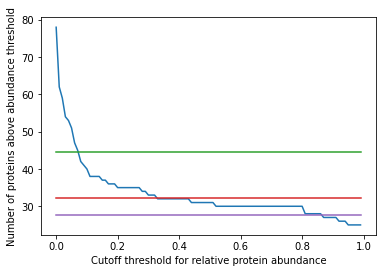

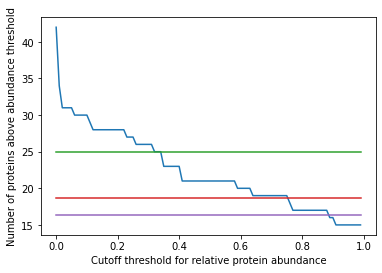

In [10]:
### Let this help you choose classification method ###


##### NO EDITS REQUIRED UNELSS THE NAMING COLUMN IS CHANGED #########


### OTSU's Method ####
print("Otsu's Method (Plasma, CSF)")
plasma_otsu_data = plasma_mass_spec_data['NP average'].to_numpy() 
csf_otsu_data = csf_mass_spec_data['NP average'].to_numpy()
merged_otsu_data = np.concatenate([plasma_otsu_data, csf_otsu_data])

criteria_plas = threshold_otsu(plasma_otsu_data)
criteria_csf = threshold_otsu(csf_otsu_data)


# prints cutoff criteria
print(criteria_plas, criteria_csf)


###### Travis's Homemade Exponential Method #####
data_sheets = [plasma_mass_spec_data, csf_mass_spec_data]
fluids_type_list = ['plasma', 'csf']
#Find proteins that are <1 & >0 abundance
for k in range(2):
    sheet = data_sheets[k]
    fluid_type = fluids_type_list[k]

    print(f'\n{fluid_type.capitalize()} \n')

    num_proteins = np.zeros(100)
    for i in np.arange(0,100,1):
        thresh = i/100
        index = (sheet['NP average']>thresh)
        num_proteins[i] = (np.count_nonzero(index))
        
    fig, (ax1) = plt.subplots()

    #The number of proteins resembles an exponential, i.e. Laplace, distribution.
    #Subtract minimum to make baseline 0 because we are only looking at 
    #proteins <1 to determine threshold.
    #We define our threshold as the point where the number of proteins drops to 1/e^{x},
    #where x is a positive nonzero integer, analogous to a decay constant.
    #Note, there are several proteins with abundance >1, we subtract them out for this threshold
    #to set our baseline to 0, but they are added back later when we use the threshold 
    #on the full dataset because they will naturally be above the threshold we calculate.
    num_proteins_above_1_abundance = min(num_proteins)
    biexponent_dist = num_proteins - num_proteins_above_1_abundance
    #set baseline to 0
    x = np.arange(0,1,.01)
    ax1.plot(x,num_proteins, num_proteins_above_1_abundance)
    ax1.set_xlabel('Cutoff threshold for relative protein abundance')
    ax1.set_ylabel('Number of proteins above abundance threshold')

    for thresh_power in [1,2,3]:
        num_protein_thresh = np.max(biexponent_dist)/pow(np.e,thresh_power)
        cutoff_thresh_value = min(x[(biexponent_dist<num_protein_thresh)&(biexponent_dist>0)])
        num_proteins_in_corona = num_protein_thresh + num_proteins_above_1_abundance
        print('Threshold power: '+ str(thresh_power) + \
            ', Abundance cutoff threshold: '+ str(cutoff_thresh_value) + \
            ', Number of proteins in corona: ' + str(int(num_proteins_in_corona))) # The number of proteins with abundance above threshold

        ax1.plot(x,num_protein_thresh*np.ones(100)+num_proteins_above_1_abundance)

    #I suggest that in addition to including proteins whose NP abundance is above our calculated
    #threshold, we should also include proteins whose NP fold change is above 1, even if their
    #NP average abundance is lower than our threshold.

    print('\nnow with fold change')
    for thresh_power in [1,2,3]:
        num_protein_thresh = np.max(biexponent_dist)/pow(np.e,thresh_power)
        cutoff_thresh_value = min(x[(biexponent_dist<num_protein_thresh)&(biexponent_dist>0)])
        index = (sheet['NP average']>cutoff_thresh_value) | (sheet['NP fold change']>1)
        num_proteins_in_corona = np.count_nonzero(sheet['NP average'][index])
        print(num_protein_thresh, cutoff_thresh_value)
        print('Threshold power: '+ str(thresh_power) + \
            ', Number of proteins in corona: ' + str(num_proteins_in_corona))

In [ ]:
### NO NEED TO RUN 

#plasma_total_data_names.to_excel('output/plasma_total_power_2point25.xlsx')
#csf_total_data_names.to_excel('output/csf_total_power_2point25.xlsx')

### Generate data sets for classification
features_plasma = plasma_total_data_names.copy()
# features_plasma = features_plasma.drop(['Accession', 'Corona', 'Entry', 'Protein names', 'Sequence', 'InterPro', 'Gene ontology IDs', 'Length'], axis=1)
features_plasma = features_plasma.drop(['Accession', 'Corona', 'Entry', 'entry', 'Protein names', 'Sequence', 'Length', 'Mass'], axis=1)

names_plasma = plasma_total_data_names['Corona'].copy()

features_csf = csf_total_data_names.copy()
# features_csf = features_csf.drop(['Accession', 'Corona', 'Entry', 'Protein names', 'InterPro', 'Gene ontology IDs','Sequence', 'Length'], axis=1)
features_csf = features_csf.drop(['Accession', 'Corona', 'Entry', 'entry', 'Protein names', 'Sequence', 'Length', 'Mass'], axis=1) 
names_csf = csf_total_data_names['Corona'].copy()

### create a merged set
features_plasma_labeled = features_plasma.copy()
features_csf_labeled = features_csf.copy()

features_plasma_labeled['phase_plasma'] = 1
features_csf_labeled['phase_plasma'] = 0

features_merged = features_plasma_labeled.append(features_csf_labeled, ignore_index=True)
names_merged = names_plasma.append(names_csf, ignore_index=True)

# set with no phase labeling names are identical to names merged
features_merged_naive = features_merged.drop(['phase_plasma'], axis=1)

print(plasma_total_data_names.shape, csf_total_data_names.shape)

## Download Data Based Off of Interpro Numbers

In [57]:
unfinished_df = pd.read_excel('2020-09-14 proteins to test_v2.xlsx', sheet_name='Trial 2', header=0)['uniprot']

In [58]:
counter =0
for i in unfinished_df:
    
    #print(i, len(i))
    if len(str(i)) >= 15:
        print('here')
        unfinished_df.at[counter] = np.NaN
        
    counter += 1 

only_uniprot = unfinished_df.dropna()

In [59]:
only_uniprot#.at[16] = np.NaN

0         P10636
1         P05067
2         Q9NZ42
3         Q96BI3
4         Q8WW43
5         Q9Y5Z0
6         P37840
7         P42212
8     A0A059PIR9
9         Q9U6Y8
10        Q8MU52
11        B7G0R2
12        Q9LMM2
13        P92949
14        F4I4K7
15        Q8W110
16        Q9FLW2
17        Q8RWS6
18        Q3KTM0
19        Q8VY13
20        O03042
21        P10795
Name: uniprot, dtype: object

In [2]:
import urllib.request
import json


def protein_data_scraping(accession_number):
    """
        Searches the interpro database based on the uniprot accession number and returns a JSON with the found data.
        Designed to suppress errors but print that it found one.

        :param accession_number: Uniprot accession number as a string
        :type accession_number: str

        :return: JSON / Dictionary
    """

    # url for API
    base_url = 'https://www.ebi.ac.uk/interpro/api/entry/interpro/protein/uniprot/'

    current_url = base_url + accession_number

    try:
        # Fetch data
        with urllib.request.urlopen(current_url) as url:
            data = json.loads(url.read().decode())  # unpack
            return data

    except json.JSONDecodeError:  # if data cant be found just pass it
        print(f'Data not found for {accession_number} (Decode error)')
        return None

In [40]:
pprint(only_uniprot.loc[2])

'P16112'


In [41]:
pprint(plasma_raw_data.columns)

Index(['Entry', 'Protein names', 'Status', 'Protein families', 'Length',
       'Mass', 'Sequence', 'Binding site', 'Calcium binding', 'DNA binding',
       'Metal binding', 'Nucleotide binding', 'Site', 'Function [CC]',
       'Absorption', 'Active site', 'Activity regulation',
       'Catalytic activity', 'Cofactor', 'EC number', 'Kinetics', 'Pathway',
       'pH dependence', 'Redox potential', 'Rhea Ids',
       'Temperature dependence', 'Interacts with', 'Subunit structure [CC]',
       'Induction', 'Tissue specificity', 'Gene ontology (biological process)',
       'Gene ontology (GO)', 'Gene ontology (molecular function)',
       'Gene ontology IDs', 'ChEBI', 'ChEBI (Catalytic activity)',
       'ChEBI (Cofactor)', 'ChEBI IDs', 'Intramembrane',
       'Subcellular location [CC]', 'Transmembrane', 'Topological domain',
       'Chain', 'Cross-link', 'Disulfide bond', 'Glycosylation',
       'Initiator methionine', 'Lipidation', 'Modified residue', 'Peptide',
       'Propeptide', 'Po

In [139]:
col_string ='' 
counter= 0
first_pass=True
for i in csf_raw_data.columns:
    if first_pass:
        col_string = query_lookup_table.loc[query_lookup_table['Column names as displayed on website'] == i,
                             'Column names as displayed in URL'].values[0]
        first_pass = False
    else:
        try: col_string += ','+query_lookup_table.loc[query_lookup_table['Column names as displayed on website'] == i,
                             'Column names as displayed in URL'].values[0]
        except: print(counter, i)
    counter += 1
print(col_string)

16 Activity regulation
id,protein names,reviewed,families,length,mass,sequence,feature(BINDING SITE),FEATURE(CALCIUM BINDING),feature(DNA BINDING),feature(METAL BINDING),feature(NP BIND),feature(SITE),comment(FUNCTION),comment(ABSORPTION),feature(ACTIVE SITE),comment(CATALYTIC ACTIVITY),comment(COFACTOR),ec,comment(KINETICS),comment(PATHWAY),comment(PH DEPENDENCE),comment(REDOX POTENTIAL),rhea-id,comment(TEMPERATURE DEPENDENCE),interactor,comment(SUBUNIT),comment(INDUCTION),comment(TISSUE SPECIFICITY),go(biological process),go,go(molecular function),go-id,chebi,chebi(Catalytic activity),chebi(Cofactor),chebi-id,feature(INTRAMEMBRANE),comment(SUBCELLULAR LOCATION),feature(TRANSMEMBRANE),feature(TOPOLOGICAL DOMAIN),feature(CHAIN),feature(CROSS LINK),feature(DISULFIDE BOND),feature(GLYCOSYLATION),feature(INITIATOR METHIONINE),feature(LIPIDATION),feature(MODIFIED RESIDUE),feature(PEPTIDE),feature(PROPEPTIDE),comment(PTM),feature(SIGNAL),feature(TRANSIT),feature(BETA STRAND),feature(HELIX),

In [84]:
html_list = pd.read_html('https://www.uniprot.org/help/uniprotkb_column_names')
query_lookup_table = pd.DataFrame()

first_pass = True
for i in range(len(html_list)):
    if first_pass:
        query_lookup_table = html_list[i]
        first_pass = False
    else: query_lookup_table = query_lookup_table.append(html_list[i],ignore_index=True)
        
query_lookup_table = query_lookup_table.append({'Column names as displayed on website':'Status','Column names as displayed in URL':'reviewed'}, ignore_index=True)
query_lookup_table

,Column names as displayed on website,Column names as displayed in URL
0,Entry,id
1,Entry name,entry name
2,Gene names,genes
3,Gene names (primary),genes(PREFERRED)
4,Gene names (synonym),genes(ALTERNATIVE)
...,...,...
175,Taxonomic identifier (VARIETAS),lineage-id(VARIETAS)
176,Taxonomic identifier (FORMA),lineage-id(FORMA)
177,db_abbrev,database(db_abbrev)
178,e.g. EMBL,database(EMBL)


In [3]:
query_lookup_table.to_excel('query_lookup_table.xlsx')

NameError: name 'query_lookup_table' is not defined

In [6]:
import pandas as pd

def uniprot_data_scraping(uniprot_list, data_to_pull='standard'):
    """
        Searches the uniprot database based on the supplied list of uniprot numbers and returns a Pandas DataFrame
        with the found data. Designed to suppress errors but print that it found one.

        :param accession_number: Uniprot accession number as a string
        :type accession_number: str
        
        :param data_to_pull: Which columns should be pulled from the UniProt Database. 
        This does not guarantee the data will populate. Rather this attempts to find the above data. Choices: all, standard, or list of columns.

        :return: DataFrame 
    """
    
    # Pull in lookup codes
    query_lookup_table = pd.read_excel('query_lookup_table.xlsx', header=0)
    
    # Identify the columns that we want to search for
    if data_to_pull == 'standard': # standard columns
        data_to_pull = ['Entry', 'Protein names', 'Status', 'Protein families', 'Length',
       'Mass', 'Sequence', 'Binding site', 'Calcium binding', 'DNA binding',
       'Metal binding', 'Nucleotide binding', 'Site', 'Function [CC]',
       'Absorption', 'Active site', 'Activity regulation',
       'Catalytic activity', 'Cofactor', 'EC number', 'Kinetics', 'Pathway',
       'pH dependence', 'Redox potential', 'Rhea Ids',
       'Temperature dependence', 'Interacts with', 'Subunit structure [CC]',
       'Induction', 'Tissue specificity', 'Gene ontology (biological process)',
       'Gene ontology (GO)', 'Gene ontology (molecular function)',
       'Gene ontology IDs', 'ChEBI', 'ChEBI (Catalytic activity)',
       'ChEBI (Cofactor)', 'ChEBI IDs', 'Intramembrane',
       'Subcellular location [CC]', 'Transmembrane', 'Topological domain',
       'Chain', 'Cross-link', 'Disulfide bond', 'Glycosylation',
       'Initiator methionine', 'Lipidation', 'Modified residue', 'Peptide',
       'Propeptide', 'Post-translational modification', 'Signal peptide',
       'Transit peptide', 'Beta strand', 'Helix', 'Turn', 'Coiled coil',
       'Compositional bias', 'Domain [CC]', 'Domain [FT]', 'Motif', 'Region',
       'Repeat', 'Zinc finger']
    
    elif data_to_pull == 'all': # all columns that we have keys for
        data_to_pull=query_lookup_table['Column names as displayed on website'].values
        
    elif type(data_to_pull) == list: # specific names that we can lookup
        data_to_pull = data_to_pull # do nothing
        
    else: # doesnt fit the specified values
        raise ValueError('Change data_to_pull to "any", "standard" or a list of column names')
    
    
    col_string = '' #create the search column string
    first_pass=True
    for col in data_to_pull: # connect together the columns that need to be separated by commas 
        if first_pass:
            col_string = query_lookup_table.loc[query_lookup_table['Column names as displayed on website'] == col,
                                 'Column names as displayed in URL'].values[0]
            first_pass = False
        else:
            try: col_string += ','+query_lookup_table.loc[query_lookup_table['Column names as displayed on website'] == col,
                                 'Column names as displayed in URL'].values[0]
            except: print(f"Coult not find URL Name for {i}")
    
    col_string = col_string.replace(' ', '%20')
    
    
    query_string_suffix= "&format=tab&columns="+col_string
    query_string_prefix='https://www.uniprot.org/uniprot/?query='
    
    first_pass=True
    for uniprot in uniprot_list:
        print(uniprot)
        if first_pass:
            total_data = pd.read_csv(query_string_prefix+uniprot+query_string_suffix, sep='\t',  thousands=',')
            first_pass = False
        else:
            try: total_data = total_data.append(pd.read_csv(query_string_prefix+uniprot+query_string_suffix, sep='\t',  thousands=','), ignore_index=True)
            except: print(f"Could not complete URL request for {uniprot}")
    
    total_data=total_data.fillna(0)
    
    return total_data
    



In [216]:
print(only_uniprot)

0     Q92752
1     O14594
2     P16112
3     Q96GW7
4     P13611
5     P16070
6     Q07021
7     P10915
8     P01130
9     P14222
10    P14778
11    P27930
12    P08887
13    P19438
14    Q07954
15    P45452
18    P61823
19    P13491
20    P00698
22    Q9ZPQ7
Name: uniprot, dtype: object


In [6]:
import pandas as pd

def uniprot_data_scraping(uniprot_list, data_to_pull='standard'):
    """
        Searches the uniprot database based on the supplied list of uniprot numbers and returns a Pandas DataFrame
        with the found data. Designed to suppress errors but print that it found one.

        :param accession_number: Uniprot accession number as a string
        :type accession_number: str
        
        :param data_to_pull: Which columns should be pulled from the UniProt Database. 
        This does not guarantee the data will populate. Rather this attempts to find the above data. Choices: all, standard, or list of columns.

        :return: DataFrame 
    """
    
    # Pull in lookup codes
    query_lookup_table = pd.read_excel('query_lookup_table.xlsx', header=0)
    
    # Identify the columns that we want to search for
    if data_to_pull == 'standard': # standard columns
        data_to_pull = ['Entry', 'Protein names', 'Status', 'Protein families', 'Length',
       'Mass', 'Sequence', 'Binding site', 'Calcium binding', 'DNA binding',
       'Metal binding', 'Nucleotide binding', 'Site', 'Function [CC]',
       'Absorption', 'Active site',
       'Catalytic activity', 'Cofactor', 'EC number', 'Kinetics', 'Pathway',
       'pH dependence', 'Redox potential', 'Rhea Ids',
       'Temperature dependence', 'Interacts with', 'Subunit structure [CC]',
       'Induction', 'Tissue specificity', 'Gene ontology (biological process)',
       'Gene ontology (GO)', 'Gene ontology (molecular function)',
       'Gene ontology IDs', 'ChEBI', 'ChEBI (Catalytic activity)',
       'ChEBI (Cofactor)', 'ChEBI IDs', 'Intramembrane',
       'Subcellular location [CC]', 'Transmembrane', 'Topological domain',
       'Chain', 'Cross-link', 'Disulfide bond', 'Glycosylation',
       'Initiator methionine', 'Lipidation', 'Modified residue', 'Peptide',
       'Propeptide', 'Post-translational modification', 'Signal peptide',
       'Transit peptide', 'Beta strand', 'Helix', 'Turn', 'Coiled coil',
       'Compositional bias', 'Domain [CC]', 'Domain [FT]', 'Motif', 'Region',
       'Repeat', 'Zinc finger']
    
    elif data_to_pull == 'all': # all columns that we have keys for
        data_to_pull=query_lookup_table['Column names as displayed on website'].values
        
    elif type(data_to_pull) == list: # specific names that we can lookup
        data_to_pull = data_to_pull # do nothing
        
    else: # doesnt fit the specified values
        raise ValueError('Change data_to_pull to "any", "standard" or a list of column names')
    
    
    col_string = '' #create the search column string
    first_pass=True
    for col in data_to_pull: # connect together the columns that need to be separated by commas 
        if first_pass:
            col_string = query_lookup_table.loc[query_lookup_table['Column names as displayed on website'] == col,
                                 'Column names as displayed in URL'].values[0]
            first_pass = False
            
        else:
            try: col_string += ','+query_lookup_table.loc[query_lookup_table['Column names as displayed on website'] == col,
                                 'Column names as displayed in URL'].values[0]
                
            except: print(f"Could not find URL Name for {col}")
    
    col_string = col_string.replace(' ', '%20') #get rid of spaces
    
    # create prefix and suffix to web address 
    query_string_suffix= "&format=tab&columns="+col_string
    query_string_prefix='https://www.uniprot.org/uniprot/?query='
    
    first_pass=True
    for uniprot in uniprot_list: #go through list of all proteins
        if first_pass: # initialize the dataframe 
            try:
                total_data = pd.read_csv(query_string_prefix+uniprot+query_string_suffix, sep='\t',  thousands=',') # get data
                
                if total_data.shape[0] > 1: # Only take correct row, sometimes UniProt sends back more than 1 response
                    total_data = total_data.loc[total_data.Entry==uniprot]
                first_pass = False # dont come back here  
                
            except: 
                print(f"Could not complete URL request for {uniprot}")
            
            
        else:
            try: 
                revolve_data = pd.read_csv(query_string_prefix+uniprot+query_string_suffix, sep='\t',  thousands=',') # get data
                
                if revolve_data.shape[0] > 1: # Only take correct row, sometimes UniProt sends back more than 1 response
                    revolve_data = revolve_data.loc[revolve_data.Entry==uniprot]
                    print(revolve_data.shape)
                total_data = total_data.append(revolve_data, ignore_index=True) 
                
            except: 
                print(f"Could not complete URL request for {uniprot}")
            
            
    
    total_data=total_data.fillna(0) # fill nans with zeros
    
    return total_data
    
    
if __name__ == "__main__": 
    test_df = uniprot_data_scraping(['P61823'],data_to_pull='standard')
    print(test_df)

    Entry                                      Protein names    Status  \
3  P61823  Ribonuclease pancreatic (EC 4.6.1.18) (RNase 1...  reviewed   

                 Protein families  Length   Mass  \
3  Pancreatic ribonuclease family     150  16461   

                                            Sequence  \
3  MALKSLVLLSLLVLVLLLVRVQPSLGKETAAAKFERQHMDSSTSAA...   

                                        Binding site  DNA binding  \
3  BINDING 33;  /note="Substrate"; BINDING 36;  /...          0.0   

   Metal binding  ...                                              Helix  \
3            0.0  ...  HELIX 30..38;  /evidence="ECO:0000244|PDB:6ETK...   

                                                Turn Coiled coil  \
3  TURN 59..62;  /evidence="ECO:0000244|PDB:6ETK"...         0.0   

   Compositional bias Domain [CC] Domain [FT]  Motif  \
3                   0           0           0      0   

                                      Region  Repeat  Zinc finger  
3  REGION 67..71;  /not

In [15]:
test_data = uniprot_data_scraping(only_uniprot_data) # replace with only_uniprot_data for no netsurf p
test_data.shape

(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)


(1000, 63)

In [10]:
# abcd = test_data.iloc[[10, 20, 30, 40]].copy()
# abcd = abcd.drop(index=[20, 30])
# abcd
testing_cleaned.columns

Index(['Entry', 'Protein names', 'Sequence', 'Length', 'Mass', 'frac_aa_A',
       'frac_aa_C', 'frac_aa_D', 'frac_aa_E', 'frac_aa_F', 'frac_aa_G',
       'frac_aa_H', 'frac_aa_I', 'frac_aa_K', 'frac_aa_L', 'frac_aa_M',
       'frac_aa_N', 'frac_aa_P', 'frac_aa_Q', 'frac_aa_R', 'frac_aa_S',
       'frac_aa_T', 'frac_aa_V', 'frac_aa_W', 'frac_aa_Y', 'molecular_weight',
       'aromaticity', 'instability_index', 'flexability_mean',
       'flexability_std', 'flexability_var', 'flexability_max',
       'flexability_min', 'flexability_median', 'isoelectric_point',
       'secondary_structure_fraction_helix',
       'secondary_structure_fraction_turn',
       'secondary_structure_fraction_sheet',
       'secondary_structure_fraction_disordered'],
      dtype='object')

In [19]:
test_data_done.to_excel('complete_cytoplasm_features_biopy_996_plas_normed.xlsx')

In [13]:
entry_list = entry_check[0]['Entry']
# entry_list = pd.read_excel('covid_entries.xlsx', header=0)['Entry']

In [14]:
verification_set = uniprot_data_scraping(entry_list)

verification_set['Calcium binding'] = 0
verification_set['Activity regulation'] = 0
verification_cleaned_data = clean_up_data_biopy(verification_set)


plasma_raw_data = pd.read_excel(data_file, sheet_name= plasma_prop_sheet, thousands=',')
plasma_cleaned_data = clean_up_data_biopy(plasma_raw_data)
plasma_cleaned_data, test_cleaned_data = normalize_mass_length(plasma_cleaned_data, verification_cleaned_data)

# netsurfp_verification_data = pd.read_excel('netsurfp_verification_data_processed_nucleus.xlsx')

# verification_complete_data = pd.merge(verification_cleaned_data, netsurfp_verification_data, left_on='Entry', right_on='entry')


# for df in [verification_complete_data]:
#     for col in ['asa_sum']:
#         df[col+'_normalized'] = df[col] / df['Mass']
test_cleaned_data.head()
# verification_complete_data.head()

(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)
(1, 63)


,Entry,Protein names,Sequence,Length,Mass,frac_aa_A,frac_aa_C,frac_aa_D,frac_aa_E,frac_aa_F,...,flexability_max,flexability_min,flexability_median,isoelectric_point,secondary_structure_fraction_helix,secondary_structure_fraction_turn,secondary_structure_fraction_sheet,secondary_structure_fraction_disordered,length,mass
0,O43236,Septin-4 (Apoptosis-related protein in the TGF...,MDRSLGWQGNSVPEDRTEAGIKRFLEDTTDDGELSKFVKDFSGNAS...,478,55098,0.046025,0.016736,0.081590,0.085774,0.043933,...,1.068036,0.928286,1.010036,5.767395,0.265690,0.213389,0.228033,0.292887,0.069426,0.069180
1,Q13228,Methanethiol oxidase (MTO) (EC 1.8.3.4) (56 kD...,MATKCGNCGPGYSTPLEAMKGPREEIVYLPCIYRNTGTEAPDYLAT...,472,52391,0.044492,0.021186,0.063559,0.055085,0.031780,...,1.081988,0.925583,1.000893,5.931091,0.324153,0.266949,0.228814,0.180085,0.068555,0.065781
2,Q9BQ15,SOSS complex subunit B1 (Nucleic acid-binding ...,MTTETFVKDIKPGLKNLNLIFIVLETGRVTKTKDGHEVRTCKVADK...,211,22338,0.047393,0.014218,0.037915,0.042654,0.023697,...,1.056024,0.945643,1.016393,9.172668,0.199052,0.393365,0.146919,0.260664,0.030646,0.028047
3,Q6ZVD7,Storkhead-box protein 1 (Winged-helix domain-c...,MARPVQLAPGSLALVLCRLEAQKAAGAAEEPGGRAVFRAFRRANAR...,989,110962,0.062690,0.017189,0.048534,0.074823,0.034378,...,1.080464,0.944714,1.008536,7.819397,0.240647,0.261881,0.239636,0.257836,0.143646,0.139322
4,Q96FS4,Signal-induced proliferation-associated protei...,MPMWAGGVGSPRRGMAPASTDDLFARKLRQPARPPLTPHTFEPRPV...,1042,112149,0.102687,0.012476,0.041267,0.072937,0.033589,...,1.075286,0.931452,1.005381,6.158997,0.238964,0.283109,0.302303,0.175624,0.151344,0.140813


In [17]:
verification_data_done=verification_complete_data.drop(['Entry', 'entry', 'Sequence', 'Length', 'Mass'], axis=1)
verification_data_done.to_excel('complete_verification_features_biopy_nucleus.xlsx')

In [ ]:
#### Bare Data ####

verification_set = uniprot_data_scraping(entry_list)

verification_set['Calcium binding'] = 0
verification_set['Activity regulation'] = 0
verification_cleaned_data = clean_up_testing_v2(verification_set)


plasma_raw_data = pd.read_excel(data_file, sheet_name= plasma_prop_sheet, thousands=',')
plasma_cleaned_data = clean_up_testing_v2(plasma_raw_data)
plasma_cleaned_data, test_cleaned_data = normalize_mass_length(plasma_cleaned_data, verification_cleaned_data)

netsurfp_verification_data = pd.read_excel('netsurfp_verification_data_processed.xlsx')

verification_complete_data = pd.merge(verification_cleaned_data, netsurfp_verification_data, left_on='Entry', right_on='entry')


for df in [verification_complete_data]:
    for col in ['asa_sum']:
        df[col+'_normalized'] = df[col] / df['Mass']

verification_complete_data.head()

